In [1]:
# MUY IMPORTANTE, Devido a las ultimas actualizaciones, ocurridas recientemente, éste modelo funciona con una versión específica de openai. Asegúrate de instalar la versión correcta:
# pip uninstall openai
# pip install openai==0.27.8

In [2]:
!pip install -q openai azure-search-documents python-dotenv transformers scikit-learn matplotlib seaborn numpy spacy tiktoken
!python -m spacy download es_core_news_sm > /dev/null 2>&1 # el " > /dev/null 2>&1 " es para que no se impriman todas las librerias en la salida, solo las excepciones


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Instalar las librerías necesarias 2

import os
import openai
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from azure.core.pipeline.policies import RetryPolicy 
from dotenv import load_dotenv, find_dotenv
from transformers import pipeline
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import tiktoken

In [4]:
# Cargar archivo .env
dotenv_path = find_dotenv()
if dotenv_path:
    print(f"Archivo .env encontrado en: {dotenv_path}")
    load_dotenv(dotenv_path)
else:
    print("Archivo .env no encontrado. Asegúrate de que exista y esté en la ruta correcta.")

Archivo .env encontrado en: /Users/luisalbertocerelli/Desktop/00-Todo/14_Hackaton_Real/00_MAIN_DE_MAIN/03_Modelo_Alucinacion_y_matriz_confusion/.env


### Configuración de credenciales para Azure Cognitive Search y OpenAI
* Inicializa las variables necesarias para conectarse a servicios de Azure Cognitive Search y OpenAI.
* Configura el cliente OpenAI con la clave API.
* Configura el cliente de Azure Search con credenciales y el nombre del índice.

In [5]:
# Variables necesarias para Azure AI Search
AZURE_SEARCH_ENDPOINT = os.getenv("SEARCH_SERVICE_ENDPOINT", "").strip()
AZURE_SEARCH_KEY = os.getenv("SEARCH_API_KEY", "").strip()
INDEX_NAME = os.getenv("INDEX_NAME", "").strip()

In [6]:
# Variables necesarias para OpenAI
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "").strip()
MODEL_NAME = os.getenv("MODEL_NAME", "text-embedding-ada-002").strip()

In [7]:
# Configurar cliente OpenAI
openai.api_key = OPENAI_API_KEY

# Configuración para Azure OpenAI
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT", "").strip()
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY", "").strip()
ENGINE_NAME = os.getenv("ENGINE_NAME", MODEL_NAME)

if AZURE_OPENAI_ENDPOINT and AZURE_OPENAI_KEY:
    openai.api_type = "azure"
    openai.api_base = AZURE_OPENAI_ENDPOINT
    openai.api_version = "2023-03-15-preview"
    openai.api_key = AZURE_OPENAI_KEY

In [8]:
# Cliente de Azure Cognitive Search
search_client = SearchClient(
    endpoint=AZURE_SEARCH_ENDPOINT,
    index_name=INDEX_NAME,
    credential=AzureKeyCredential(AZURE_SEARCH_KEY)
)

### Pipeline de factualidad en español e ingles
* Inicializa un pipeline de "mrm8488/bert-multi-cased-finetuned-xquadv1" especializado en preguntas y respuestas para evaluar factualidad en español e ingles.

In [9]:

# Carga pipeline de factualidad en español con el modelo "mrm8488/bert-multi-cased-finetuned-xquadv1" que es tanto para ingles como español.
factual_pipeline = pipeline(
    "question-answering",
    model="mrm8488/bert-multi-cased-finetuned-xquadv1",
    tokenizer="mrm8488/bert-multi-cased-finetuned-xquadv1",
    framework="pt"
)

Some weights of the model checkpoint at mrm8488/bert-multi-cased-finetuned-xquadv1 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


### Funciones de manejo de texto y tokens
* contar_tokens: Calcula la cantidad de tokens en un texto para un modelo específico.
* dividir_texto_en_fragmentos: Divide un texto en fragmentos que no exceden el límite de tokens del modelo.

In [10]:
# Función para medir tokens
def contar_tokens(texto, modelo="text-embedding-ada-002"):
    """Cuenta la cantidad de tokens en un texto usando el modelo especificado."""
    tokenizador = tiktoken.encoding_for_model(modelo)
    return len(tokenizador.encode(texto))

In [11]:
# Función para dividir texto en fragmentos más pequeños
def dividir_texto_en_fragmentos(texto, max_tokens=8192):
    """Divide un texto en fragmentos que no excedan el límite de tokens del modelo."""
    tokenizador = tiktoken.encoding_for_model("text-embedding-ada-002")
    tokens = tokenizador.encode(texto)

    for i in range(0, len(tokens), max_tokens):
        yield tokenizador.decode(tokens[i:i + max_tokens])

### Funciones para validar y calcular embeddings
* validar_embeddings: Verifica que un embedding no contenga valores inválidos.
* obtener_embeddings_batch: Calcula embeddings para un lote de textos con validación y manejo de fragmentos.

In [12]:
# Función para validar embeddings
def validar_embeddings(embedding):
    """Valida que el embedding no contenga NaN o valores inválidos."""
    if embedding is None or not np.isfinite(embedding).all():
        return False
    return True

In [13]:
# Función para obtener embeddings usando batching con validación
def obtener_embeddings_batch(textos):
    """Obtiene embeddings para un lote de textos en una sola solicitud, con validación."""
    embeddings_cache = []
    for texto in textos:
        if not texto or not texto.strip():
            print(f"Advertencia: Texto vacío o no válido detectado. Texto: '{texto}'")
            embeddings_cache.append(None)
            continue

        fragmentos = list(dividir_texto_en_fragmentos(texto, max_tokens=8192))
        embedding_total = []

        for fragmento in fragmentos:
            try:
                response = openai.Embedding.create(
                    input=fragmento,
                    engine=ENGINE_NAME
                )
                embedding_fragmento = response['data'][0]['embedding']

                if not validar_embeddings(embedding_fragmento):
                    embeddings_cache.append(None)
                    break

                embedding_total.append(embedding_fragmento)
            except Exception as e:
                embeddings_cache.append(None)
                break

        if embedding_total:
            embeddings_cache.append(np.mean(embedding_total, axis=0))
        else:
            embeddings_cache.append(None)

    return embeddings_cache

### Función para verificar factualidad
* verificar_factualidad_respuesta: Combina el pipeline de factualidad y la similitud de embeddings para determinar si una respuesta es factual.

In [14]:
# Función para verificar factualidad
def verificar_factualidad_respuesta(respuesta, documentos_referencia, umbral=0.6):
    """Verifica la factualidad combinando pipeline y similitud semántica utilizando embeddings de OpenAI."""
    scores_factualidad = []
    scores_similitud = []

    for doc in documentos_referencia:
        resultado = factual_pipeline(question=respuesta, context=doc["content"])
        scores_factualidad.append(resultado["score"])

        emb_respuesta = obtener_embeddings_batch([respuesta])[0]
        emb_contexto = obtener_embeddings_batch([doc["content"]])[0]

        if emb_respuesta is None or emb_contexto is None:
            continue

        similarity = cosine_similarity([emb_respuesta], [emb_contexto])[0][0]
        scores_similitud.append(similarity)

    avg_factualidad = np.mean(scores_factualidad) if scores_factualidad else 0
    avg_similitud = np.mean(scores_similitud) if scores_similitud else 0

    peso_factualidad = 0.4
    peso_similitud = 0.6
    puntaje_total = (avg_factualidad * peso_factualidad) + (avg_similitud * peso_similitud)
    es_factual = puntaje_total >= umbral
    return puntaje_total, es_factual

### Funciones de evaluación
* evaluar_respuesta: Evalúa si una respuesta es factual, utilizando documentos de Azure y embeddings.
* buscar_en_azure: Realiza una búsqueda en Azure Cognitive Search para obtener documentos relevantes.

In [15]:
# Evaluar respuesta
def evaluar_respuesta(respuesta):
    """Evalúa si la respuesta es factual."""
    documentos = buscar_en_azure(respuesta)
    if not documentos:
        print("Advertencia: No se encontraron documentos. Evaluación como alucinación.")
    return len(documentos) > 0  # Evalúa si hay resultados

In [16]:
def buscar_en_azure(query, index_name="documentos-huella"):
    """Busca documentos en un índice de Azure Search."""
    try:
        # Recuperar las credenciales desde las variables de entorno
        search_service_endpoint = os.getenv("SEARCH_SERVICE_ENDPOINT")
        search_api_key = os.getenv("SEARCH_API_KEY")

        # Verificar que las credenciales estén disponibles
        if not search_service_endpoint or not search_api_key:
            raise ValueError("Las credenciales de Azure Search no están definidas correctamente en el entorno.")

        # Configurar el cliente con políticas de reintento
        retry_policy = RetryPolicy(total_retries=3)
        search_client = SearchClient(
            endpoint=search_service_endpoint,
            index_name=index_name,
            credential=AzureKeyCredential(search_api_key),
            retry_policy=retry_policy
        )

        # Recuperar documentos en lotes de 100
        resultados = search_client.search(query, top=100)
        documentos = []
        for r in resultados:
            documentos.append({
                "id": r.get("id", "unknown"),
                "content": r.get("content", ""),
                "source": r.get("@search.documentkey", "unknown_source")
            })
        return documentos
    except Exception as e:
        print(f"Error al buscar en el índice {index_name}: {e}")
        return []

### Generación y evaluación de datos para métricas
* generar_datos_para_matriz: Genera predicciones y etiquetas reales para comparar respuestas con su ground truth.

In [17]:
# Generar datos para matriz de confusión
def generar_datos_para_matriz(respuestas_y_groundtruth):
    """Genera predicciones y etiquetas reales."""
    resultados = []
    for entrada in respuestas_y_groundtruth:
        respuesta = entrada["respuesta"]
        groundtruth = entrada["groundtruth"]
        prediccion = evaluar_respuesta(respuesta)
        resultados.append({"groundtruth": groundtruth, "prediction": prediccion})
    return resultados

### Visualización y análisis de resultados
* calcular_matriz_confusion: Calcula y muestra la matriz de confusión y el informe de clasificación.

In [18]:
def calcular_matriz_confusion(resultados):
    """Calcula y visualiza la matriz de confusión."""
    groundtruth = [r["groundtruth"] for r in resultados]
    prediction = [r["prediction"] for r in resultados]

    # Depuración
    print("Groundtruth:", groundtruth)
    print("Prediction:", prediction)

    cm = confusion_matrix(groundtruth, prediction, labels=[0, 1])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Factual", "Alucinación"], yticklabels=["Factual", "Alucinación"])
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

    print(classification_report(
        groundtruth,
        prediction,
        target_names=["Factual", "Alucinación"],
        labels=[0, 1]
    ))

### Flujo principal
* Define un conjunto de datos de respuestas y ground truth.
* Genera resultados a partir de las respuestas.
* Calcula y visualiza la matriz de confusión para evaluar el modelo.

Respuesta: 1, Predicción: True
Respuesta: 0, Predicción: True
Groundtruth: [1, 0]
Prediction: [True, True]


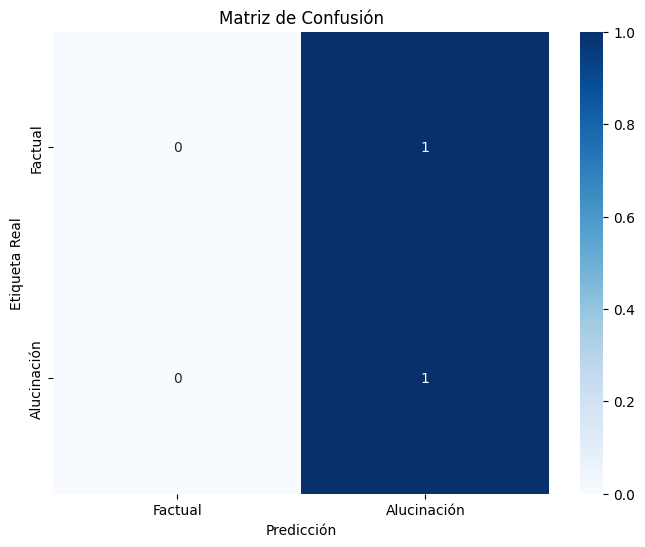

              precision    recall  f1-score   support

     Factual       0.00      0.00      0.00         1
 Alucinación       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [19]:
if __name__ == "__main__":
    respuestas_y_groundtruth = [
        {
            "respuesta": "Placas solares elevadas permiten usar el espacio para agricultura.",
            "groundtruth": 1
        },
        {
            "respuesta": "Los paneles solares absorben CO2 del aire.",
            "groundtruth": 0
        }
    ]

    resultados = generar_datos_para_matriz(respuestas_y_groundtruth)

    # Depura resultados
    for resultado in resultados:
        print(f"Respuesta: {resultado['groundtruth']}, Predicción: {resultado['prediction']}")

    calcular_matriz_confusion(resultados)